# IMPORTING LIBRARIES:

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import random
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# READING THE DATASET:

In [2]:
train_dir = r'H:\M.tech Data science PDPU\Sem-2\Capstone Project\Brain Tumor\Dataset\Training'
test_dir = r'H:\M.tech Data science PDPU\Sem-2\Capstone Project\Brain Tumor\Dataset\Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    # Construct full path to the label directory
    label_dir = os.path.join(train_dir, label)
    # Iterate through images in each class directory
    for image in os.listdir(label_dir):
        # Construct full path to each image
        image_path = os.path.join(label_dir, image)
        train_paths.append(image_path)
        train_labels.append(label)

# Shuffle the data
train_paths, train_labels = shuffle(train_paths, train_labels)

### Creating a pie chart 




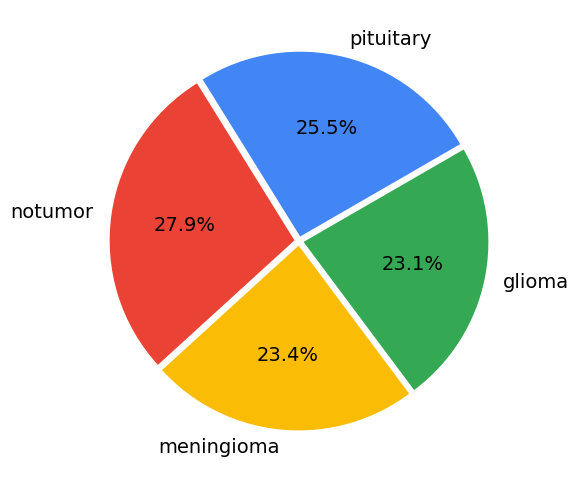

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# Dateset is Reasonably Balanced.

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    # Construct full path to the label directory
    label_dir = os.path.join(test_dir, label)
    # Iterate through images in each class directory
    for image in os.listdir(label_dir):
        # Construct full path to each image
        image_path = os.path.join(label_dir, image)
        test_paths.append(image_path)
        test_labels.append(label)

# Shuffle the data
test_paths, test_labels = shuffle(test_paths, test_labels)

### Creating a pie chart 




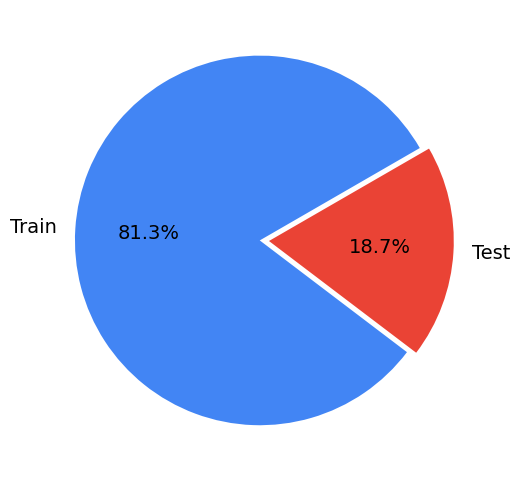

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# DATA AUGMENTATION:

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

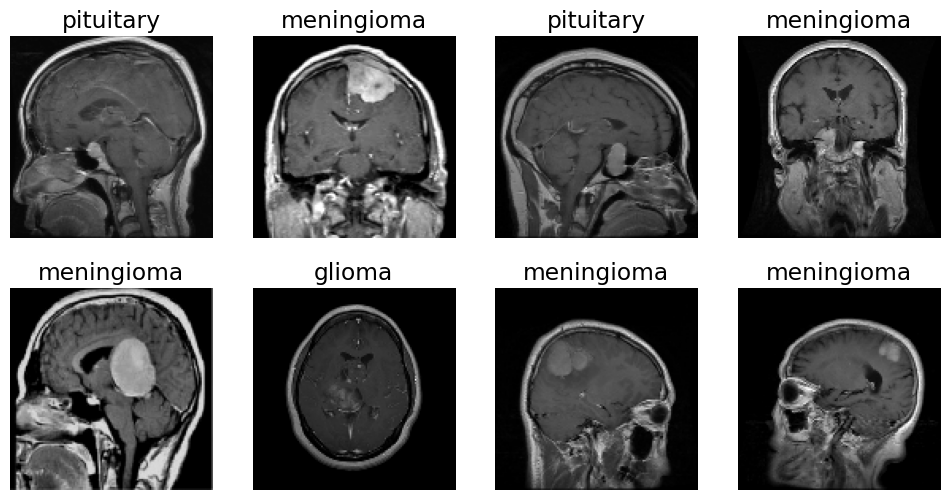

In [7]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# DATA GENERATOR 

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

### Model Summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

### Model Complie

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# TRAINING THE MODEL:

In [12]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/8
285/285 [==============================] - 671s 2s/step - loss: 0.4525 - sparse_categorical_accuracy: 0.8254
Epoch 2/8
285/285 [==============================] - 570s 2s/step - loss: 0.2305 - sparse_categorical_accuracy: 0.9136
Epoch 3/8
285/285 [==============================] - 576s 2s/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9443
Epoch 4/8
285/285 [==============================] - 552s 2s/step - loss: 0.0960 - sparse_categorical_accuracy: 0.9643
Epoch 5/8
285/285 [==============================] - 569s 2s/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9659
Epoch 6/8
285/285 [==============================] - 569s 2s/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9731
Epoch 7/8
285/285 [==============================] - 590s 2s/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9819
Epoch 8/8
285/285 [==============================] - 561s 2s/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9814


## Creating a plot of the training history of the model

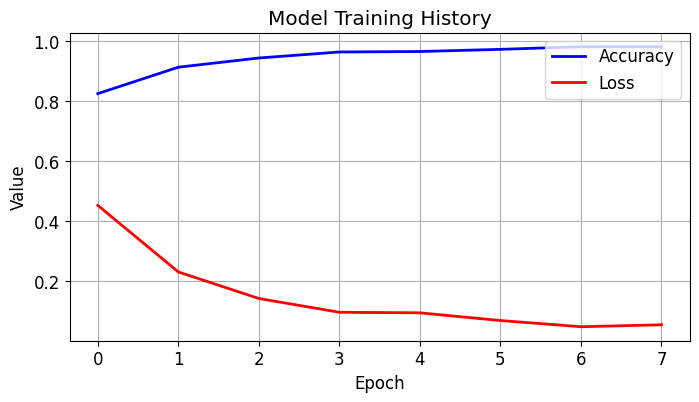

In [13]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

# EVALUATING MODEL WITH TEST SAMPLES:

In [14]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|██                                                                                 | 1/40 [00:03<02:35,  4.00s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:07<02:12,  3.48s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:10<02:00,  3.25s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:13<01:53,  3.15s/it]

1/1 [==============================] - 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:16<01:50,  3.14s/it]

1/1 [==============================] - 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:18<01:37,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:21<01:36,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████▌                                                                  | 8/40 [00:24<01:35,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████▋                                                                | 9/40 [00:27<01:32,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:30<01:31,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:33<01:28,  3.05s/it]

1/1 [==============================] - 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:36<01:24,  3.02s/it]

1/1 [==============================] - 3s 3s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:40<01:23,  3.09s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:43<01:19,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:46<01:16,  3.06s/it]

1/1 [==============================] - 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:49<01:12,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:52<01:09,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:55<01:05,  2.99s/it]

1/1 [==============================] - 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:57<01:02,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [01:00<00:59,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [01:03<00:56,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [01:06<00:53,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [01:09<00:51,  3.00s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [01:12<00:48,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [01:15<00:45,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [01:19<00:42,  3.01s/it]

1/1 [==============================] - 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:21<00:38,  2.98s/it]

1/1 [==============================] - 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:24<00:35,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:27<00:32,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:30<00:29,  2.96s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:33<00:26,  2.97s/it]

1/1 [==============================] - 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:35<00:21,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:38<00:19,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:41<00:16,  2.82s/it]

1/1 [==============================] - 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:44<00:14,  2.88s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:47<00:11,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:50<00:08,  2.93s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:53<00:05,  2.95s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:55<00:02,  2.72s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:58<00:00,  2.79s/it]

1/1 [==============================] - 3s 3s/step


41it [02:02,  3.00s/it]                                                                                                


## Classification Report

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.94      0.95       300
  meningioma       0.93      0.97      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



# Test The Images

In [16]:
def names(number):
    if number==0:
        return 'No, Its not a tumor'
    else:
        return 'Its a Tumor'

In [17]:
from PIL import Image

100.0% Conclusion: Its a Tumor


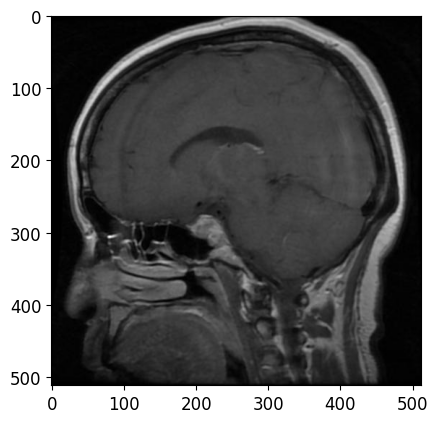

In [18]:
from matplotlib.pyplot import imshow
img = Image.open(r"H:\M.tech Data science PDPU\Sem-2\Capstone Project\Brain Tumor\Dataset\Testing\pituitary\Te-piTr_0004.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


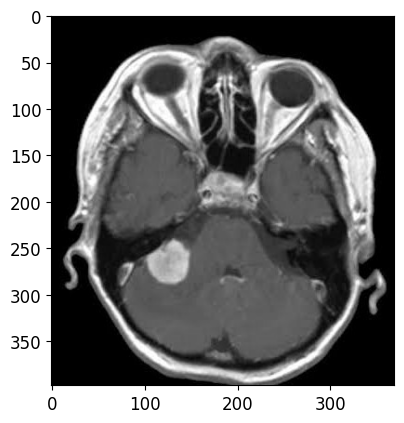

In [19]:
from matplotlib.pyplot import imshow
img = Image.open(r"H:\M.tech Data science PDPU\Sem-2\Capstone Project\Brain Tumor\Dataset\Testing\meningioma\Te-me_0048.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: No, Its not a tumor


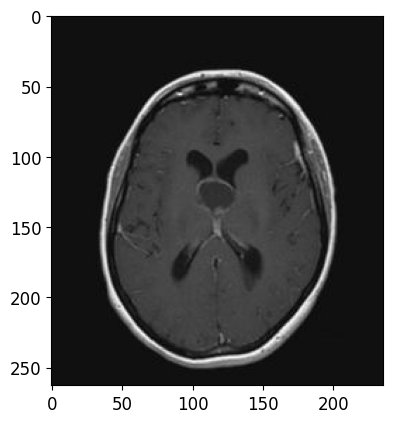

In [20]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'   
from matplotlib.pyplot import imshow
img = Image.open(r"H:\M.tech Data science PDPU\Sem-2\Capstone Project\Brain Tumor\Dataset\Testing\notumor\Te-no_0035.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

# 2nd Model: CNN

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam

In [48]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# Add convolutional and pooling layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Add fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(unique_labels), activation='softmax'))

cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 128)      

In [49]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [50]:
# Train the model
batch_size = 32
steps = int(len(train_paths) / batch_size)
epochs = 10
history_1 = cnn_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
178/178 [==============================] - 94s 521ms/step - loss: 0.8726 - sparse_categorical_accuracy: 0.6296
Epoch 2/10
178/178 [==============================] - 99s 560ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.7734
Epoch 3/10
178/178 [==============================] - 101s 567ms/step - loss: 0.4660 - sparse_categorical_accuracy: 0.8222
Epoch 4/10
178/178 [==============================] - 100s 561ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.8484
Epoch 5/10
178/178 [==============================] - 99s 557ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.8593
Epoch 6/10
178/178 [==============================] - 100s 564ms/step - loss: 0.3274 - sparse_categorical_accuracy: 0.8732
Epoch 7/10
178/178 [==============================] - 103s 581ms/step - loss: 0.2881 - sparse_categorical_accuracy: 0.8886
Epoch 8/10
178/178 [==============================] - 100s 559ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.9062
Epoch 9/10
178/178 

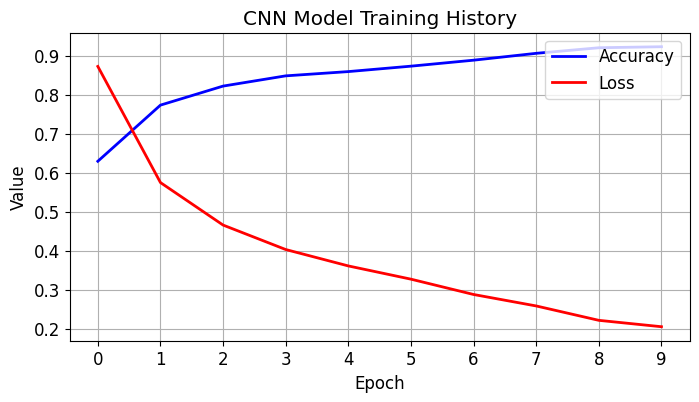

In [65]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_1.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_1.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('CNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_1.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [54]:
# Evaluate the model
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_1 = []
y_true_1 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_1 = cnn_model.predict(x)
    pred_1 = np.argmax(pred_1, axis=-1)
    y_pred_1.extend(decode_label(pred_1))
    y_true_1.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


  2%|██                                                                                 | 1/40 [00:00<00:09,  3.99it/s]

1/1 [==============================] - 0s 100ms/step


  5%|████▏                                                                              | 2/40 [00:00<00:08,  4.32it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██████▏                                                                            | 3/40 [00:00<00:08,  4.46it/s]

1/1 [==============================] - 0s 100ms/step


 10%|████████▎                                                                          | 4/40 [00:00<00:07,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


 12%|██████████▍                                                                        | 5/40 [00:01<00:07,  4.41it/s]

1/1 [==============================] - 0s 112ms/step


 15%|████████████▍                                                                      | 6/40 [00:01<00:08,  4.13it/s]

1/1 [==============================] - 0s 131ms/step


 18%|██████████████▌                                                                    | 7/40 [00:01<00:08,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 20%|████████████████▌                                                                  | 8/40 [00:02<00:09,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 22%|██████████████████▋                                                                | 9/40 [00:02<00:08,  3.48it/s]

1/1 [==============================] - 0s 137ms/step


 25%|████████████████████▌                                                             | 10/40 [00:02<00:08,  3.38it/s]

1/1 [==============================] - 0s 101ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:02<00:08,  3.59it/s]

1/1 [==============================] - 0s 99ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:03<00:07,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:03<00:06,  4.13it/s]

1/1 [==============================] - 0s 97ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:03<00:06,  4.28it/s]

1/1 [==============================] - 0s 98ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:03<00:05,  4.41it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:03<00:05,  4.48it/s]

1/1 [==============================] - 0s 130ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:04<00:05,  4.10it/s]

1/1 [==============================] - 0s 133ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:04<00:05,  3.84it/s]

1/1 [==============================] - 0s 106ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:04<00:05,  3.92it/s]

1/1 [==============================] - 0s 138ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:05<00:05,  3.82it/s]

1/1 [==============================] - 0s 115ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:05<00:04,  3.89it/s]

1/1 [==============================] - 0s 100ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:05<00:04,  4.08it/s]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:05<00:04,  3.69it/s]

1/1 [==============================] - 0s 110ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:06<00:04,  3.83it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:06<00:03,  4.02it/s]

1/1 [==============================] - 0s 127ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:06<00:03,  4.01it/s]

1/1 [==============================] - 0s 122ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:06<00:03,  3.89it/s]

1/1 [==============================] - 0s 98ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:07<00:02,  4.08it/s]

1/1 [==============================] - 0s 113ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:07<00:02,  4.19it/s]

1/1 [==============================] - 0s 124ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:07<00:02,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:07<00:02,  4.14it/s]

1/1 [==============================] - 0s 129ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:08<00:01,  4.04it/s]

1/1 [==============================] - 0s 112ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:08<00:01,  4.01it/s]

1/1 [==============================] - 0s 99ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:08<00:01,  4.19it/s]

1/1 [==============================] - 0s 135ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:08<00:01,  4.10it/s]

1/1 [==============================] - 0s 108ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:09<00:00,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:09<00:00,  4.25it/s]

1/1 [==============================] - 0s 134ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:09<00:00,  4.01it/s]

1/1 [==============================] - 0s 140ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:09<00:00,  3.77it/s]

1/1 [==============================] - 0s 103ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.95it/s]

1/1 [==============================] - 0s 97ms/step


41it [00:10,  4.00it/s]                                                                                                


In [55]:
# Classification report
print(classification_report(y_true_1, y_pred_1))

              precision    recall  f1-score   support

      glioma       0.84      0.91      0.87       300
  meningioma       0.86      0.83      0.85       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.99      0.92      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



# 3rd model: DenseNet Model

In [56]:
from tensorflow.keras.applications import DenseNet121

In [57]:
# Load the DenseNet121 model without the top layers
base_model_2 = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_2.layers:
    layer.trainable = False


29084464/29084464 [==============================] - 10s 0us/step


In [58]:
# Set some layers to trainable if needed (example here, modify as necessary)
base_model_2.layers[-2].trainable = True
base_model_2.layers[-3].trainable = True
base_model_2.layers[-4].trainable = True

In [60]:
# Create the full model
densenet_model = Sequential()
densenet_model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
densenet_model.add(base_model_2)
densenet_model.add(Flatten())
densenet_model.add(Dropout(0.3))
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.2))
densenet_model.add(Dense(len(unique_labels), activation='softmax'))

densenet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_6 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_11 (Dropout)        (None, 16384)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               2097280   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 4)                 516       
                                                                 
Total params: 9135300 (34.85 MB)
Trainable params: 213

In [61]:
# Compile the model
densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])


In [64]:
# Train the model
batch_size = 32
steps_2 = int(len(train_paths) / batch_size)
epochs = 10

history_2 = densenet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                             epochs=epochs, steps_per_epoch=steps_2)

Epoch 1/10
178/178 [==============================] - 188s 1s/step - loss: 0.4455 - sparse_categorical_accuracy: 0.8341
Epoch 2/10
178/178 [==============================] - 199s 1s/step - loss: 0.2703 - sparse_categorical_accuracy: 0.8947
Epoch 3/10
178/178 [==============================] - 201s 1s/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9261
Epoch 4/10
178/178 [==============================] - 201s 1s/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9410
Epoch 5/10
178/178 [==============================] - 203s 1s/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9456
Epoch 6/10
178/178 [==============================] - 204s 1s/step - loss: 0.1153 - sparse_categorical_accuracy: 0.9586
Epoch 7/10
178/178 [==============================] - 202s 1s/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9636
Epoch 8/10
178/178 [==============================] - 201s 1s/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9717
Epoch 9/10
178/178 [====================

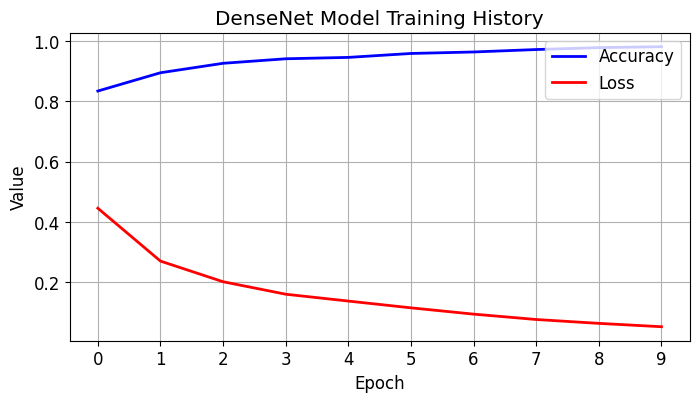

In [66]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_2.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_2.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('DenseNet Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_2.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [67]:
# Evaluate the model
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_2 = []
y_true_2 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_2 = densenet_model.predict(x)
    pred_2 = np.argmax(pred_2, axis=-1)
    y_pred_2.extend(decode_label(pred_2))
    y_true_2.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|██                                                                                 | 1/40 [00:03<02:18,  3.56s/it]

1/1 [==============================] - 1s 688ms/step


  5%|████▏                                                                              | 2/40 [00:04<01:13,  1.94s/it]

1/1 [==============================] - 1s 678ms/step


  8%|██████▏                                                                            | 3/40 [00:05<00:52,  1.42s/it]

1/1 [==============================] - 1s 681ms/step


 10%|████████▎                                                                          | 4/40 [00:05<00:42,  1.18s/it]

1/1 [==============================] - 1s 1s/step


 12%|██████████▍                                                                        | 5/40 [00:07<00:42,  1.22s/it]

1/1 [==============================] - 1s 770ms/step


 15%|████████████▍                                                                      | 6/40 [00:08<00:38,  1.14s/it]

1/1 [==============================] - 1s 679ms/step


 18%|██████████████▌                                                                    | 7/40 [00:09<00:34,  1.03s/it]

1/1 [==============================] - 1s 1s/step


 20%|████████████████▌                                                                  | 8/40 [00:10<00:36,  1.13s/it]

1/1 [==============================] - 1s 725ms/step


 22%|██████████████████▋                                                                | 9/40 [00:11<00:33,  1.07s/it]

1/1 [==============================] - 1s 908ms/step


 25%|████████████████████▌                                                             | 10/40 [00:12<00:32,  1.08s/it]

1/1 [==============================] - 1s 1s/step


 28%|██████████████████████▌                                                           | 11/40 [00:13<00:32,  1.14s/it]

1/1 [==============================] - 1s 708ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:14<00:29,  1.05s/it]

1/1 [==============================] - 1s 831ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:27,  1.04s/it]

1/1 [==============================] - 1s 786ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:25,  1.00it/s]

1/1 [==============================] - 1s 683ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:17<00:23,  1.06it/s]

1/1 [==============================] - 1s 689ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:18<00:21,  1.11it/s]

1/1 [==============================] - 1s 1s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:19<00:22,  1.01it/s]

1/1 [==============================] - 1s 883ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:20<00:23,  1.05s/it]

1/1 [==============================] - 1s 788ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:21<00:21,  1.02s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:23<00:24,  1.23s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:24<00:25,  1.32s/it]

1/1 [==============================] - 1s 751ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:25<00:21,  1.20s/it]

1/1 [==============================] - 1s 790ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:26<00:19,  1.13s/it]

1/1 [==============================] - 1s 697ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:27<00:16,  1.04s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:28<00:16,  1.10s/it]

1/1 [==============================] - 1s 819ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:29<00:15,  1.09s/it]

1/1 [==============================] - 1s 670ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:30<00:12,  1.00it/s]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:32<00:13,  1.16s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:33<00:13,  1.23s/it]

1/1 [==============================] - 1s 736ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:34<00:11,  1.15s/it]

1/1 [==============================] - 1s 682ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:35<00:09,  1.04s/it]

1/1 [==============================] - 1s 1s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:36<00:09,  1.13s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:37<00:08,  1.23s/it]

1/1 [==============================] - 1s 790ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:38<00:07,  1.17s/it]

1/1 [==============================] - 1s 671ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:39<00:05,  1.06s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:41<00:04,  1.15s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:42<00:03,  1.20s/it]

1/1 [==============================] - 1s 793ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:43<00:02,  1.15s/it]

1/1 [==============================] - 1s 671ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:44<00:01,  1.04s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:45<00:00,  1.10s/it]

1/1 [==============================] - 4s 4s/step


41it [00:49,  1.22s/it]                                                                                                


In [68]:
# Classification report
print(classification_report(y_true_2, y_pred_2))

              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91       300
  meningioma       0.88      0.94      0.91       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



# 4rth Model: ResNet50 Model

In [69]:
from tensorflow.keras.applications import ResNet50

In [74]:
# Load the ResNet50 model without the top layers
base_model_3 = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_3.layers:
    layer.trainable = False

In [75]:
# Set the last few layers to trainable
base_model_3.layers[-2].trainable = True
base_model_3.layers[-3].trainable = True
base_model_3.layers[-4].trainable = True

In [76]:
# Create the full model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_3)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_15 (Dropout)        (None, 32768)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 4)                 516       
                                                                 
Total params: 27782660 (105.98 MB)
Trainable params: 5

In [77]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [78]:
# Train the model
batch_size = 32
steps_4 = int(len(train_paths) / batch_size)
epochs = 10
history_4 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_4)

Epoch 1/10
178/178 [==============================] - 191s 1s/step - loss: 0.7983 - sparse_categorical_accuracy: 0.6691
Epoch 2/10
178/178 [==============================] - 202s 1s/step - loss: 0.5860 - sparse_categorical_accuracy: 0.7551
Epoch 3/10
178/178 [==============================] - 206s 1s/step - loss: 0.5273 - sparse_categorical_accuracy: 0.7864
Epoch 4/10
178/178 [==============================] - 204s 1s/step - loss: 0.4816 - sparse_categorical_accuracy: 0.7995
Epoch 5/10
178/178 [==============================] - 204s 1s/step - loss: 0.4363 - sparse_categorical_accuracy: 0.8195
Epoch 6/10
178/178 [==============================] - 203s 1s/step - loss: 0.4299 - sparse_categorical_accuracy: 0.8289
Epoch 7/10
178/178 [==============================] - 205s 1s/step - loss: 0.4079 - sparse_categorical_accuracy: 0.8280
Epoch 8/10
178/178 [==============================] - 204s 1s/step - loss: 0.3791 - sparse_categorical_accuracy: 0.8463
Epoch 9/10
178/178 [====================

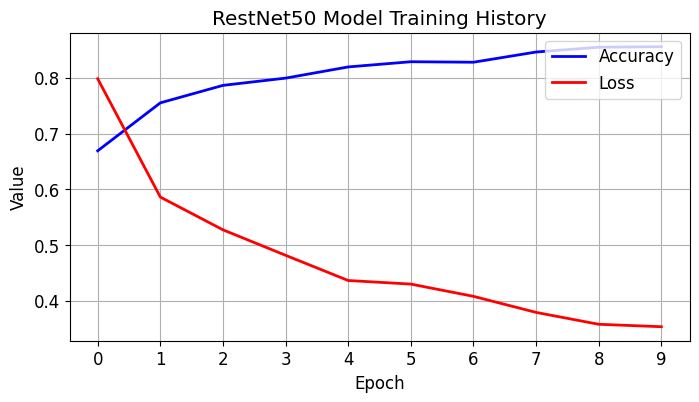

In [79]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_4.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_4.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('RestNet50 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_4.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [80]:
# Evaluate the model
batch_size = 32
steps_4 = int(len(test_paths) / batch_size)
y_pred_3 = []
y_true_3 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_4):
    pred_3 = model.predict(x)
    pred_3 = np.argmax(pred_3, axis=-1)
    y_pred_3.extend(decode_label(pred_3))
    y_true_3.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  2%|██                                                                                 | 1/40 [00:04<02:38,  4.05s/it]

1/1 [==============================] - 1s 1s/step


  5%|████▏                                                                              | 2/40 [00:05<01:32,  2.44s/it]

1/1 [==============================] - 1s 1s/step


  8%|██████▏                                                                            | 3/40 [00:06<01:10,  1.91s/it]

1/1 [==============================] - 1s 993ms/step


 10%|████████▎                                                                          | 4/40 [00:07<00:58,  1.64s/it]

1/1 [==============================] - 1s 956ms/step


 12%|██████████▍                                                                        | 5/40 [00:09<00:51,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 15%|████████████▍                                                                      | 6/40 [00:10<00:47,  1.39s/it]

1/1 [==============================] - 1s 1s/step


 18%|██████████████▌                                                                    | 7/40 [00:11<00:44,  1.34s/it]

1/1 [==============================] - 1s 958ms/step


 20%|████████████████▌                                                                  | 8/40 [00:12<00:40,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 22%|██████████████████▋                                                                | 9/40 [00:13<00:39,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 25%|████████████████████▌                                                             | 10/40 [00:15<00:37,  1.26s/it]

1/1 [==============================] - 1s 1s/step


 28%|██████████████████████▌                                                           | 11/40 [00:16<00:36,  1.27s/it]

1/1 [==============================] - 1s 1s/step


 30%|████████████████████████▌                                                         | 12/40 [00:17<00:35,  1.28s/it]

1/1 [==============================] - 1s 1s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:19<00:34,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:20<00:33,  1.29s/it]

1/1 [==============================] - 1s 1s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:21<00:32,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:22<00:31,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:24<00:30,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:25<00:28,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:26<00:27,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:28<00:26,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:29<00:24,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:30<00:23,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:32<00:22,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:33<00:20,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:34<00:19,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:36<00:18,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:37<00:17,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:38<00:15,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:39<00:14,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:41<00:13,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:42<00:11,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:43<00:10,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:45<00:09,  1.31s/it]

1/1 [==============================] - 1s 1s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:46<00:07,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:47<00:06,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:49<00:05,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:50<00:03,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:51<00:02,  1.30s/it]

1/1 [==============================] - 1s 1s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:52<00:01,  1.30s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:54<00:00,  1.30s/it]

1/1 [==============================] - 4s 4s/step


41it [00:58,  1.42s/it]                                                                                                


In [81]:
# Classification report
print(classification_report(y_true_3, y_pred_3))

              precision    recall  f1-score   support

      glioma       0.79      0.68      0.73       300
  meningioma       0.67      0.57      0.62       306
     notumor       0.84      0.99      0.91       405
   pituitary       0.87      0.94      0.90       300

    accuracy                           0.81      1311
   macro avg       0.80      0.79      0.79      1311
weighted avg       0.80      0.81      0.80      1311



# 5th Model: MobileNetV2 Model

In [82]:
from tensorflow.keras.applications import MobileNetV2

In [83]:
# Load the MobileNetV2 model without the top layers
base_model_4 = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_4.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 3s 0us/step


In [84]:
# Set the last few layers to trainable
base_model_4.layers[-2].trainable = True
base_model_4.layers[-3].trainable = True
base_model_4.layers[-4].trainable = True

In [85]:
# Create the full model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_4)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_9 (Flatten)         (None, 20480)             0         
                                                                 
 dropout_17 (Dropout)        (None, 20480)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               2621568   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 4)                 516       
                                                     

In [86]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [87]:
# Train the model
batch_size = 20
steps_5 = int(len(train_paths) / batch_size)
epochs = 10
history_5 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_5)


Epoch 1/10
285/285 [==============================] - 89s 276ms/step - loss: 0.4452 - sparse_categorical_accuracy: 0.8465
Epoch 2/10
285/285 [==============================] - 79s 277ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.9431
Epoch 3/10
285/285 [==============================] - 79s 276ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9779
Epoch 4/10
285/285 [==============================] - 79s 276ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9816
Epoch 5/10
285/285 [==============================] - 79s 276ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9861
Epoch 6/10
285/285 [==============================] - 78s 274ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9910
Epoch 7/10
285/285 [==============================] - 78s 275ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9924
Epoch 8/10
285/285 [==============================] - 78s 275ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9942
Epoch 9/10
285/285 [====

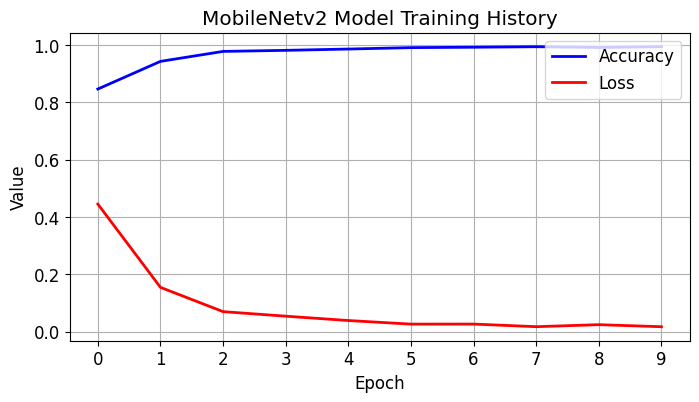

In [88]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_5.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_5.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('MobileNetv2 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_5.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [89]:
# Evaluate the model
batch_size = 32
steps_5 = int(len(test_paths) / batch_size)
y_pred_4 = []
y_true_4 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_5):
    pred_4 = model.predict(x)
    pred_4 = np.argmax(pred_4, axis=-1)
    y_pred_4.extend(decode_label(pred_4))
    y_true_4.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|██                                                                                 | 1/40 [00:02<01:53,  2.90s/it]

1/1 [==============================] - 0s 357ms/step


  5%|████▏                                                                              | 2/40 [00:03<00:58,  1.55s/it]

1/1 [==============================] - 0s 357ms/step


  8%|██████▏                                                                            | 3/40 [00:04<00:41,  1.11s/it]

1/1 [==============================] - 0s 355ms/step


 10%|████████▎                                                                          | 4/40 [00:04<00:32,  1.11it/s]

1/1 [==============================] - 0s 348ms/step


 12%|██████████▍                                                                        | 5/40 [00:05<00:27,  1.26it/s]

1/1 [==============================] - 0s 356ms/step


 15%|████████████▍                                                                      | 6/40 [00:05<00:24,  1.39it/s]

1/1 [==============================] - 0s 356ms/step


 18%|██████████████▌                                                                    | 7/40 [00:06<00:22,  1.48it/s]

1/1 [==============================] - 0s 366ms/step


 20%|████████████████▌                                                                  | 8/40 [00:07<00:20,  1.55it/s]

1/1 [==============================] - 0s 329ms/step


 22%|██████████████████▋                                                                | 9/40 [00:07<00:19,  1.62it/s]

1/1 [==============================] - 0s 309ms/step


 25%|████████████████████▌                                                             | 10/40 [00:08<00:17,  1.68it/s]

1/1 [==============================] - 0s 329ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:08<00:16,  1.73it/s]

1/1 [==============================] - 0s 357ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:09<00:16,  1.74it/s]

1/1 [==============================] - 0s 327ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:09<00:15,  1.76it/s]

1/1 [==============================] - 0s 302ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:10<00:15,  1.71it/s]

1/1 [==============================] - 0s 330ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:10<00:14,  1.73it/s]

1/1 [==============================] - 0s 312ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:11<00:14,  1.69it/s]

1/1 [==============================] - 0s 363ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:12<00:13,  1.68it/s]

1/1 [==============================] - 0s 349ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:12<00:13,  1.69it/s]

1/1 [==============================] - 0s 361ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:13<00:12,  1.69it/s]

1/1 [==============================] - 0s 320ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:13<00:11,  1.72it/s]

1/1 [==============================] - 0s 349ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:14<00:11,  1.73it/s]

1/1 [==============================] - 0s 314ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:15<00:10,  1.73it/s]

1/1 [==============================] - 0s 339ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:15<00:09,  1.78it/s]

1/1 [==============================] - 0s 352ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:16<00:09,  1.76it/s]

1/1 [==============================] - 0s 301ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:16<00:08,  1.74it/s]

1/1 [==============================] - 0s 352ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:17<00:08,  1.72it/s]

1/1 [==============================] - 0s 345ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:17<00:07,  1.72it/s]

1/1 [==============================] - 0s 345ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:18<00:06,  1.75it/s]

1/1 [==============================] - 0s 359ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:19<00:06,  1.75it/s]

1/1 [==============================] - 0s 350ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:19<00:05,  1.75it/s]

1/1 [==============================] - 0s 356ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:20<00:05,  1.76it/s]

1/1 [==============================] - 0s 352ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:20<00:04,  1.76it/s]

1/1 [==============================] - 0s 359ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:21<00:04,  1.74it/s]

1/1 [==============================] - 0s 376ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:21<00:03,  1.72it/s]

1/1 [==============================] - 0s 361ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:22<00:02,  1.69it/s]

1/1 [==============================] - 0s 343ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:23<00:02,  1.71it/s]

1/1 [==============================] - 0s 352ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:23<00:01,  1.71it/s]

1/1 [==============================] - 0s 349ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:24<00:01,  1.71it/s]

1/1 [==============================] - 0s 351ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:24<00:00,  1.72it/s]

1/1 [==============================] - 0s 352ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.73it/s]

1/1 [==============================] - 4s 4s/step


41it [00:29,  1.40it/s]                                                                                                


In [90]:
# Classification report
print(classification_report(y_true_4, y_pred_4))

              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.91      0.96      0.94       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.95      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# 6th Model: VGG19

In [91]:
from tensorflow.keras.applications import VGG19

In [92]:
# Load the base model
base_model_5 = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_5.layers:
    layer.trainable = False

In [93]:
# Set the last VGG block to trainable
base_model_5.layers[-2].trainable = True
base_model_5.layers[-3].trainable = True
base_model_5.layers[-4].trainable = True

In [94]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_5)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_19 (Dropout)        (None, 8192)              0         
                                                                 
 dense_23 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 4)                 516       
                                                                 
Total params: 21073604 (80.39 MB)
Trainable params: 8

In [95]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [96]:
# Train the model
batch_size = 32
steps_6 = int(len(train_paths) / batch_size)
epochs = 10
history_6 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_6)


Epoch 1/10
178/178 [==============================] - 640s 4s/step - loss: 0.5200 - sparse_categorical_accuracy: 0.7939
Epoch 2/10
178/178 [==============================] - 636s 4s/step - loss: 0.2835 - sparse_categorical_accuracy: 0.8893
Epoch 3/10
178/178 [==============================] - 634s 4s/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9280
Epoch 4/10
178/178 [==============================] - 634s 4s/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9405
Epoch 5/10
178/178 [==============================] - 701s 4s/step - loss: 0.1263 - sparse_categorical_accuracy: 0.9530
Epoch 6/10
178/178 [==============================] - 676s 4s/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9637
Epoch 7/10
178/178 [==============================] - 732s 4s/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9706
Epoch 8/10
178/178 [==============================] - 711s 4s/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9729
Epoch 9/10
178/178 [====================

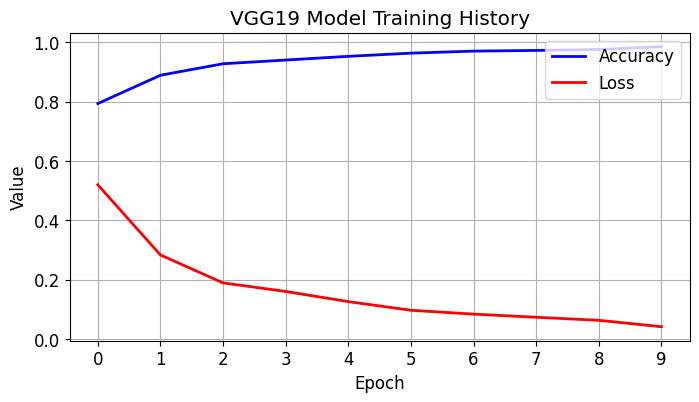

In [97]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_6.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_6.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('VGG19 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_6.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()


In [98]:
# Evaluate the model on the test set
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_5 = []
y_true_5 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_5 = model.predict(x)
    pred_5 = np.argmax(pred_5, axis=-1)
    for i in decode_label(pred_5):
        y_pred_5.append(i)
    for i in decode_label(y):
        y_true_5.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|██                                                                                 | 1/40 [00:02<01:23,  2.13s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:03<01:14,  1.96s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:06<01:13,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:08<01:12,  2.02s/it]

1/1 [==============================] - 7s 7s/step


 12%|██████████▍                                                                        | 5/40 [00:15<02:13,  3.80s/it]

1/1 [==============================] - 3s 3s/step


 15%|████████████▍                                                                      | 6/40 [00:18<02:07,  3.74s/it]

1/1 [==============================] - 3s 3s/step


 18%|██████████████▌                                                                    | 7/40 [00:21<01:58,  3.59s/it]

1/1 [==============================] - 3s 3s/step


 20%|████████████████▌                                                                  | 8/40 [00:24<01:48,  3.39s/it]

1/1 [==============================] - 3s 3s/step


 22%|██████████████████▋                                                                | 9/40 [00:27<01:39,  3.22s/it]

1/1 [==============================] - 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:30<01:30,  3.03s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:32<01:17,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:34<01:09,  2.50s/it]

1/1 [==============================] - 3s 3s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:37<01:10,  2.60s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:40<01:09,  2.69s/it]

1/1 [==============================] - 3s 3s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:42<01:07,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:45<01:04,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:47<01:01,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:50<00:58,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:53<00:55,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:55<00:52,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:58<00:49,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [01:01<00:47,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [01:03<00:44,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [01:06<00:42,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [01:09<00:39,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [01:11<00:36,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:14<00:34,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:16<00:31,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:19<00:28,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:22<00:26,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:24<00:23,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:27<00:21,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:30<00:18,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:32<00:15,  2.64s/it]

1/1 [==============================] - 3s 3s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:35<00:13,  2.69s/it]

1/1 [==============================] - 3s 3s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:38<00:10,  2.74s/it]

1/1 [==============================] - 3s 3s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:41<00:08,  2.75s/it]

1/1 [==============================] - 3s 3s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:43<00:05,  2.74s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:46<00:02,  2.71s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:49<00:00,  2.69s/it]

1/1 [==============================] - 3s 3s/step


41it [01:51,  2.73s/it]                                                                                                


In [99]:
# Classification report
print(classification_report(y_true_5, y_pred_5))

              precision    recall  f1-score   support

      glioma       0.99      0.87      0.93       300
  meningioma       0.89      0.98      0.93       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# 7th Model: EfficientNet Model

In [100]:
from tensorflow.keras.applications import EfficientNetB0

In [101]:
# Load the base model
base_model_6 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_6.layers:
    layer.trainable = False

In [102]:
# Set the last few blocks to trainable
for layer in base_model_6.layers[-20:]:
    layer.trainable = True

In [104]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_6)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten_12 (Flatten)        (None, 20480)             0         
                                                                 
 dropout_23 (Dropout)        (None, 20480)             0         
                                                                 
 dense_27 (Dense)            (None, 128)               2621568   
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 4)                 516       
                                                     

In [105]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [106]:
# Train the model
batch_size = 32
steps_7 = int(len(train_paths) / batch_size)
epochs = 8
history_7 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_7)

Epoch 1/8
178/178 [==============================] - 170s 811ms/step - loss: 1.4377 - sparse_categorical_accuracy: 0.2906
Epoch 2/8
178/178 [==============================] - 126s 711ms/step - loss: 1.3468 - sparse_categorical_accuracy: 0.3183
Epoch 3/8
178/178 [==============================] - 127s 717ms/step - loss: 1.3150 - sparse_categorical_accuracy: 0.3389
Epoch 4/8
178/178 [==============================] - 131s 736ms/step - loss: 1.3068 - sparse_categorical_accuracy: 0.3461
Epoch 5/8
178/178 [==============================] - 127s 711ms/step - loss: 1.2730 - sparse_categorical_accuracy: 0.3607
Epoch 6/8
178/178 [==============================] - 132s 742ms/step - loss: 1.2743 - sparse_categorical_accuracy: 0.3581
Epoch 7/8
178/178 [==============================] - 124s 696ms/step - loss: 1.2676 - sparse_categorical_accuracy: 0.3688
Epoch 8/8
178/178 [==============================] - 129s 722ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.3752


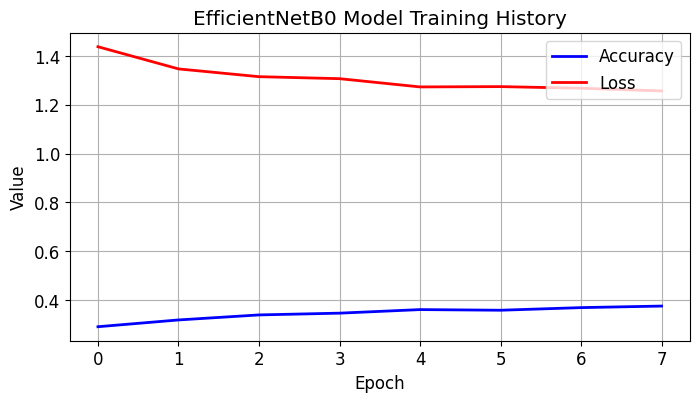

In [107]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_7.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_7.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('EfficientNetB0 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_7.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()


In [108]:
# Evaluate the model on the test set
batch_size = 32
steps_7 = int(len(test_paths) / batch_size)
y_pred_6 = []
y_true_6 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_7):
    pred_6 = model.predict(x)
    pred_6 = np.argmax(pred_6, axis=-1)
    for i in decode_label(pred_6):
        y_pred_6.append(i)
    for i in decode_label(y):
        y_true_6.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  2%|██                                                                                 | 1/40 [00:05<03:49,  5.88s/it]

1/1 [==============================] - 1s 625ms/step


  5%|████▏                                                                              | 2/40 [00:07<01:58,  3.12s/it]

1/1 [==============================] - 1s 620ms/step


  8%|██████▏                                                                            | 3/40 [00:08<01:24,  2.29s/it]

1/1 [==============================] - 1s 619ms/step


 10%|████████▎                                                                          | 4/40 [00:09<01:06,  1.85s/it]

1/1 [==============================] - 1s 620ms/step


 12%|██████████▍                                                                        | 5/40 [00:10<00:56,  1.60s/it]

1/1 [==============================] - 1s 614ms/step


 15%|████████████▍                                                                      | 6/40 [00:12<00:51,  1.50s/it]

1/1 [==============================] - 1s 618ms/step


 18%|██████████████▌                                                                    | 7/40 [00:13<00:46,  1.40s/it]

1/1 [==============================] - 1s 601ms/step


 20%|████████████████▌                                                                  | 8/40 [00:14<00:43,  1.36s/it]

1/1 [==============================] - 1s 606ms/step


 22%|██████████████████▋                                                                | 9/40 [00:15<00:40,  1.30s/it]

1/1 [==============================] - 1s 609ms/step


 25%|████████████████████▌                                                             | 10/40 [00:16<00:37,  1.26s/it]

1/1 [==============================] - 1s 580ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:18<00:36,  1.24s/it]

1/1 [==============================] - 1s 570ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:19<00:33,  1.19s/it]

1/1 [==============================] - 1s 623ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:20<00:32,  1.19s/it]

1/1 [==============================] - 1s 536ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:21<00:30,  1.16s/it]

1/1 [==============================] - 1s 620ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:22<00:29,  1.17s/it]

1/1 [==============================] - 1s 614ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:23<00:28,  1.18s/it]

1/1 [==============================] - 1s 620ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:25<00:29,  1.27s/it]

1/1 [==============================] - 1s 613ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:26<00:27,  1.24s/it]

1/1 [==============================] - 1s 601ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:27<00:25,  1.23s/it]

1/1 [==============================] - 1s 569ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:28<00:23,  1.18s/it]

1/1 [==============================] - 1s 599ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:29<00:22,  1.17s/it]

1/1 [==============================] - 1s 618ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:31<00:21,  1.19s/it]

1/1 [==============================] - 1s 642ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:32<00:21,  1.25s/it]

1/1 [==============================] - 1s 617ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:33<00:19,  1.22s/it]

1/1 [==============================] - 1s 623ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:34<00:18,  1.21s/it]

1/1 [==============================] - 1s 605ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:36<00:17,  1.23s/it]

1/1 [==============================] - 1s 611ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:37<00:16,  1.24s/it]

1/1 [==============================] - 1s 617ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:38<00:14,  1.22s/it]

1/1 [==============================] - 1s 627ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:39<00:13,  1.21s/it]

1/1 [==============================] - 1s 573ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:41<00:12,  1.26s/it]

1/1 [==============================] - 1s 623ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:42<00:11,  1.30s/it]

1/1 [==============================] - 1s 615ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:43<00:10,  1.25s/it]

1/1 [==============================] - 1s 627ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:44<00:08,  1.25s/it]

1/1 [==============================] - 1s 636ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:46<00:07,  1.23s/it]

1/1 [==============================] - 1s 611ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:47<00:06,  1.20s/it]

1/1 [==============================] - 1s 597ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:48<00:05,  1.27s/it]

1/1 [==============================] - 1s 634ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:49<00:03,  1.26s/it]

1/1 [==============================] - 1s 579ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:51<00:02,  1.27s/it]

1/1 [==============================] - 1s 591ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:52<00:01,  1.22s/it]

1/1 [==============================] - 1s 559ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.21s/it]

1/1 [==============================] - 6s 6s/step


41it [00:59,  1.45s/it]                                                                                                


In [109]:
# Classification report
print(classification_report(y_true_6, y_pred_6))

              precision    recall  f1-score   support

      glioma       0.50      0.00      0.01       300
  meningioma       0.18      0.18      0.18       306
     notumor       0.38      0.87      0.53       405
   pituitary       0.32      0.08      0.12       300

    accuracy                           0.33      1311
   macro avg       0.34      0.28      0.21      1311
weighted avg       0.35      0.33      0.24      1311



# Advanced Models 

## 8th Model: Xception Model

In [114]:
from tensorflow.keras.applications import Xception

In [115]:
# Load the base model
base_model_7 = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model_7.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model_7.layers[-20:]:
    layer.trainable = True

83683744/83683744 [==============================] - 23s 0us/step


In [116]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_7)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dropout_25 (Dropout)        (None, 32768)             0         
                                                                 
 dense_29 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 4)                 516       
                                                                 
Total params: 25056428 (95.58 MB)
Trainable params: 1

In [117]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [118]:
# Train the model
batch_size = 20
steps_8 = int(len(train_paths) / batch_size)
epochs = 8
history_8 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_8)

Epoch 1/8
285/285 [==============================] - 402s 1s/step - loss: 0.4244 - sparse_categorical_accuracy: 0.8475
Epoch 2/8
285/285 [==============================] - 403s 1s/step - loss: 0.1151 - sparse_categorical_accuracy: 0.9573
Epoch 3/8
285/285 [==============================] - 332s 1s/step - loss: 0.0538 - sparse_categorical_accuracy: 0.9801
Epoch 4/8
285/285 [==============================] - 320s 1s/step - loss: 0.0497 - sparse_categorical_accuracy: 0.9842
Epoch 5/8
285/285 [==============================] - 325s 1s/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9933
Epoch 6/8
285/285 [==============================] - 320s 1s/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9903
Epoch 7/8
285/285 [==============================] - 320s 1s/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9909
Epoch 8/8
285/285 [==============================] - 321s 1s/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9930


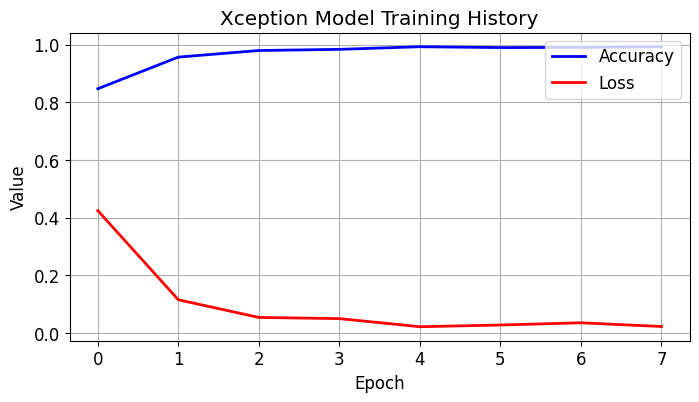

In [119]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_8.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_8.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('Xception Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_8.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [120]:
# Evaluate the model on the test set
batch_size = 32
steps_8 = int(len(test_paths) / batch_size)
y_pred_7 = []
y_true_7 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_8):
    pred_7 = model.predict(x)
    pred_7 = np.argmax(pred_7, axis=-1)
    for i in decode_label(pred_7):
        y_pred_7.append(i)
    for i in decode_label(y):
        y_true_7.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|██                                                                                 | 1/40 [00:02<01:36,  2.46s/it]

1/1 [==============================] - 1s 757ms/step


  5%|████▏                                                                              | 2/40 [00:03<01:02,  1.65s/it]

1/1 [==============================] - 1s 672ms/step


  8%|██████▏                                                                            | 3/40 [00:04<00:49,  1.35s/it]

1/1 [==============================] - 1s 672ms/step


 10%|████████▎                                                                          | 4/40 [00:05<00:43,  1.21s/it]

1/1 [==============================] - 1s 640ms/step


 12%|██████████▍                                                                        | 5/40 [00:06<00:38,  1.11s/it]

1/1 [==============================] - 1s 760ms/step


 15%|████████████▍                                                                      | 6/40 [00:07<00:38,  1.13s/it]

1/1 [==============================] - 1s 720ms/step


 18%|██████████████▌                                                                    | 7/40 [00:08<00:37,  1.15s/it]

1/1 [==============================] - 1s 695ms/step


 20%|████████████████▌                                                                  | 8/40 [00:09<00:35,  1.11s/it]

1/1 [==============================] - 1s 739ms/step


 22%|██████████████████▋                                                                | 9/40 [00:10<00:34,  1.10s/it]

1/1 [==============================] - 1s 727ms/step


 25%|████████████████████▌                                                             | 10/40 [00:11<00:32,  1.08s/it]

1/1 [==============================] - 1s 692ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:12<00:30,  1.06s/it]

1/1 [==============================] - 1s 697ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:13<00:29,  1.05s/it]

1/1 [==============================] - 1s 712ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:15<00:28,  1.04s/it]

1/1 [==============================] - 1s 664ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:16<00:26,  1.03s/it]

1/1 [==============================] - 1s 667ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:16<00:25,  1.02s/it]

1/1 [==============================] - 1s 669ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:17<00:24,  1.01s/it]

1/1 [==============================] - 1s 673ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:18<00:23,  1.00s/it]

1/1 [==============================] - 1s 670ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:19<00:21,  1.01it/s]

1/1 [==============================] - 1s 688ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:20<00:20,  1.01it/s]

1/1 [==============================] - 1s 675ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:21<00:19,  1.00it/s]

1/1 [==============================] - 1s 670ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:22<00:18,  1.01it/s]

1/1 [==============================] - 1s 675ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:23<00:17,  1.02it/s]

1/1 [==============================] - 1s 675ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:24<00:16,  1.02it/s]

1/1 [==============================] - 1s 678ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:25<00:15,  1.02it/s]

1/1 [==============================] - 1s 684ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:26<00:14,  1.02it/s]

1/1 [==============================] - 1s 686ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:27<00:13,  1.02it/s]

1/1 [==============================] - 1s 682ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:28<00:12,  1.02it/s]

1/1 [==============================] - 1s 686ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:29<00:11,  1.02it/s]

1/1 [==============================] - 1s 686ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:30<00:10,  1.02it/s]

1/1 [==============================] - 1s 697ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:31<00:09,  1.01it/s]

1/1 [==============================] - 1s 803ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:32<00:09,  1.03s/it]

1/1 [==============================] - 1s 790ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:34<00:08,  1.07s/it]

1/1 [==============================] - 1s 798ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:35<00:07,  1.09s/it]

1/1 [==============================] - 1s 806ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:36<00:06,  1.11s/it]

1/1 [==============================] - 1s 799ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:37<00:05,  1.12s/it]

1/1 [==============================] - 1s 789ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:38<00:04,  1.12s/it]

1/1 [==============================] - 1s 790ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:39<00:03,  1.13s/it]

1/1 [==============================] - 1s 784ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:40<00:02,  1.15s/it]

1/1 [==============================] - 1s 810ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:42<00:01,  1.15s/it]

1/1 [==============================] - 1s 801ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.15s/it]

1/1 [==============================] - 2s 2s/step


41it [00:45,  1.11s/it]                                                                                                


In [121]:
# Classification report
print(classification_report(y_true_7, y_pred_7))

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.92      0.96      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



## 9th Model: NasNet Model

In [123]:
from tensorflow.keras.applications import NASNetLarge

In [124]:
# Load the base model
base_model_8 = NASNetLarge(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model_8.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model_8.layers[-20:]:
    layer.trainable = True

343610240/343610240 [==============================] - 99s 0us/step


In [125]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_8)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4, 4, 4032)        84916818  
                                                                 
 flatten_14 (Flatten)        (None, 64512)             0         
                                                                 
 dropout_27 (Dropout)        (None, 64512)             0         
                                                                 
 dense_31 (Dense)            (None, 128)               8257664   
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 4)                 516       
                                                                 
Total params: 93174998 (355.43 MB)
Trainable params: 

In [126]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [128]:
# Train the model
batch_size = 32
steps_9 = int(len(train_paths) / batch_size)
epochs = 8
history_9 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_9)


Epoch 1/8
178/178 [==============================] - 496s 3s/step - loss: 0.5439 - sparse_categorical_accuracy: 0.8102
Epoch 2/8
178/178 [==============================] - 488s 3s/step - loss: 0.2662 - sparse_categorical_accuracy: 0.9023
Epoch 3/8
178/178 [==============================] - 538s 3s/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9463
Epoch 4/8
178/178 [==============================] - 491s 3s/step - loss: 0.1185 - sparse_categorical_accuracy: 0.9562
Epoch 5/8
178/178 [==============================] - 488s 3s/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9739
Epoch 6/8
178/178 [==============================] - 509s 3s/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9812
Epoch 7/8
178/178 [==============================] - 488s 3s/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9835
Epoch 8/8
178/178 [==============================] - 495s 3s/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9923


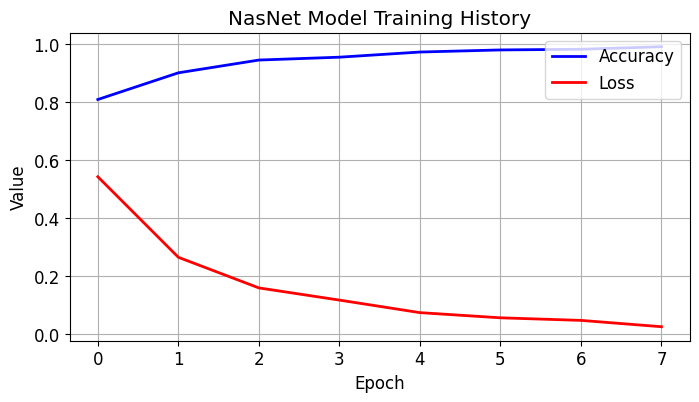

In [131]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_9.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_9.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('NasNet Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_9.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [132]:
# Evaluate the model on the test set
batch_size = 32
steps_9 = int(len(test_paths) / batch_size)
y_pred_9 = []
y_true_9 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_9):
    pred_9 = model.predict(x)
    pred_9 = np.argmax(pred_9, axis=-1)
    for i in decode_label(pred_9):
        y_pred_9.append(i)
    for i in decode_label(y):
        y_true_9.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|██                                                                                 | 1/40 [00:02<01:27,  2.24s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:04<01:25,  2.25s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:06<01:23,  2.25s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:08<01:19,  2.20s/it]

1/1 [==============================] - 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:11<01:16,  2.18s/it]

1/1 [==============================] - 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:13<01:19,  2.35s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:16<01:19,  2.42s/it]

1/1 [==============================] - 3s 3s/step


 20%|████████████████▌                                                                  | 8/40 [00:19<01:20,  2.53s/it]

1/1 [==============================] - 3s 3s/step


 22%|██████████████████▋                                                                | 9/40 [00:21<01:21,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:24<01:18,  2.62s/it]

1/1 [==============================] - 3s 3s/step


 28%|██████████████████████▌                                                           | 11/40 [00:27<01:22,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 30%|████████████████████████▌                                                         | 12/40 [00:31<01:23,  3.00s/it]

1/1 [==============================] - 3s 3s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:34<01:25,  3.17s/it]

1/1 [==============================] - 3s 3s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:37<01:22,  3.16s/it]

1/1 [==============================] - 3s 3s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:40<01:17,  3.12s/it]

1/1 [==============================] - 4s 4s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:44<01:19,  3.32s/it]

1/1 [==============================] - 3s 3s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:47<01:12,  3.16s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:50<01:06,  3.02s/it]

1/1 [==============================] - 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:52<01:01,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:55<00:57,  2.85s/it]

1/1 [==============================] - 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:58<00:53,  2.80s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [01:00<00:49,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [01:03<00:46,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [01:06<00:43,  2.72s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [01:08<00:40,  2.71s/it]

1/1 [==============================] - 3s 3s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [01:11<00:37,  2.71s/it]

1/1 [==============================] - 3s 3s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:14<00:35,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:17<00:32,  2.71s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:19<00:29,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:22<00:26,  2.70s/it]

1/1 [==============================] - 3s 3s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:25<00:24,  2.70s/it]

1/1 [==============================] - 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:27<00:21,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:30<00:18,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:33<00:16,  2.67s/it]

1/1 [==============================] - 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:35<00:13,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:38<00:10,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:41<00:07,  2.65s/it]

1/1 [==============================] - 3s 3s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:43<00:05,  2.68s/it]

1/1 [==============================] - 3s 3s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:46<00:02,  2.69s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:49<00:00,  2.72s/it]

1/1 [==============================] - 2s 2s/step


41it [01:52,  2.73s/it]                                                                                                


In [133]:
# Classification report
print(classification_report(y_true_9, y_pred_9))

              precision    recall  f1-score   support

      glioma       0.92      0.84      0.88       300
  meningioma       0.83      0.89      0.86       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.96      0.91      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



Conclusion :
